### <span style='color:blue'>AdEase Time Series - Problem Statement</span>

Ad Ease is an ads and marketing based company helping businesses elicit maximum clicks @ minimum cost. AdEase is an ad infrastructure to help businesses promote themselves easily, effectively, and economically. The interplay of 3 AI modules - Design, Dispense, and Decipher, come together to make it this an end-to-end 3 step process digital advertising solution for all.

You are working in the Data Science team of Ad ease trying to understand the per page view report for different wikipedia pages for 550 days, and forecasting the number of views so that you can predict and optimize the ad placement for your clients. You are provided with the data of 145k wikipedia pages and daily view count for each of them. Your clients belong to different regions and need data on how their ads will perform on pages in different languages.

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn
import re, datetime
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.statespace.sarimax import SARIMAX

pd.set_option('display.max_columns', 30)
warnings.filterwarnings('ignore')
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,5

In [154]:
df = pd.read_csv('train_1.csv')
exog_df = pd.read_csv('Exog_Campaign_eng.csv')

#### Visits on each article on each date

In [155]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,...,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,...,21.0,21.0,47.0,65.0,17.0,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,...,17.0,15.0,22.0,23.0,19.0,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,...,6.0,2.0,2.0,4.0,3.0,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,...,18.0,13.0,18.0,23.0,10.0,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,15.0,4.0,11.0,7.0,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [156]:
df.shape

(145063, 551)

In [157]:
df.columns[1], df.columns[-1]

('2015-07-01', '2016-12-31')

In [158]:
missing = round(df.isna().sum().sum()/(df.shape[0]*(df.shape[1]-1)) *100, 2)
print(f'Missing data is: {missing}%')

Missing data is: 7.76%


In [159]:
print(f'No value exist in {(df.isna().sum(axis=1) == 550).sum()} articles')

No value exist in 652 articles


In [160]:
counts = df.isna().sum(axis=1)
nulls = counts[(counts > 0) & (counts < 550)].sample(10)
nulls.index, nulls

(Int64Index([10811, 58812, 45092, 45690, 12893, 112037, 22975, 69428, 43628,
             112482],
            dtype='int64'),
 10811     272
 58812       2
 45092     403
 45690     305
 12893     254
 112037     34
 22975       3
 69428     381
 43628     380
 112482    158
 dtype: int64)

In [161]:
def get_sample_ts(ind):
    for i in ind:
        sample = pd.DataFrame(df.iloc[i,:])
        label = sample.iloc[0,0]
        sample.iloc[1:].plot(color='r')
        plt.title(label)
    plt.show()

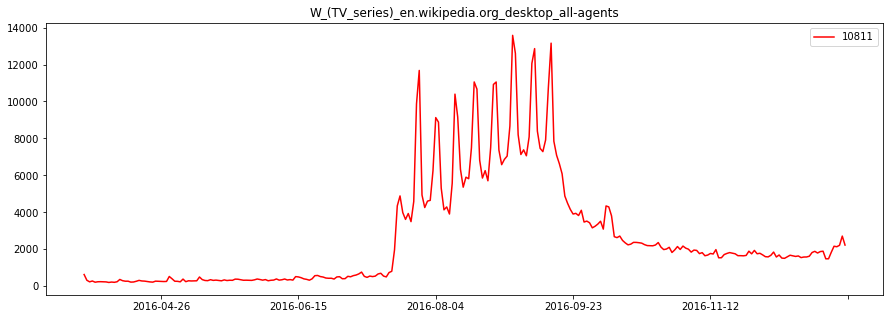

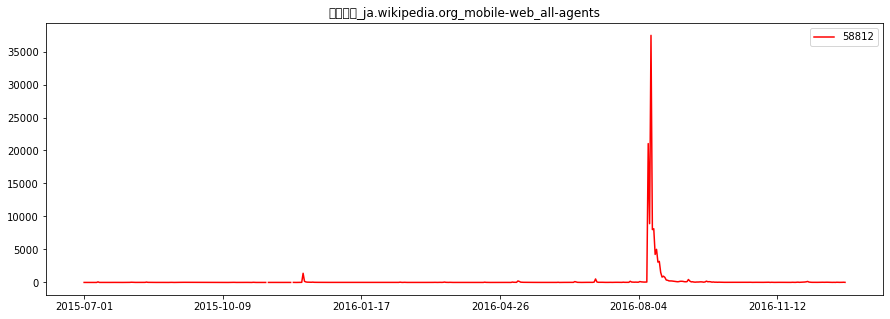

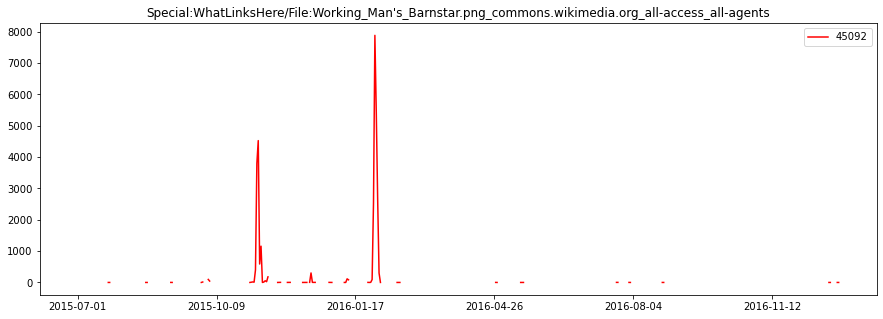

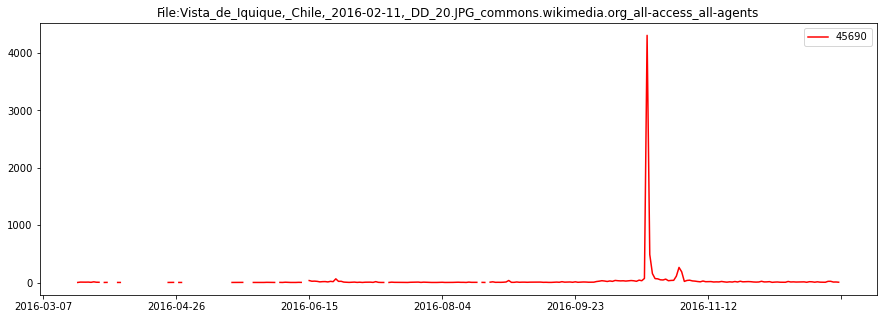

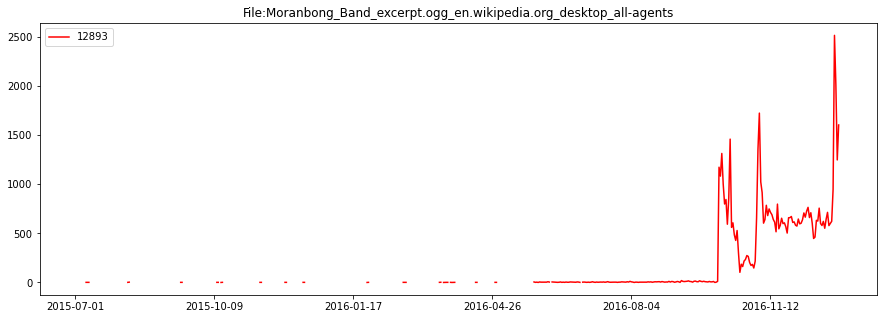

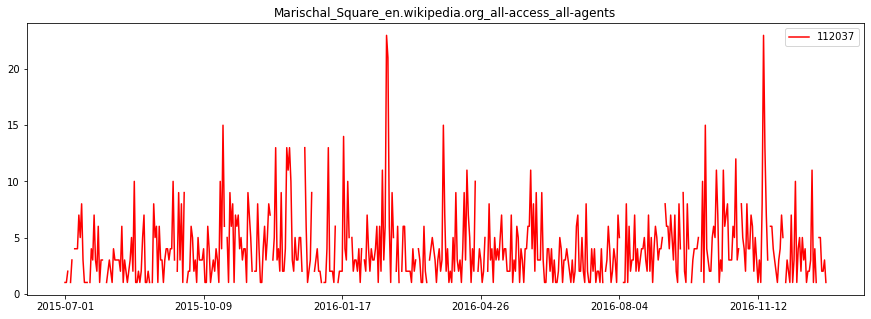

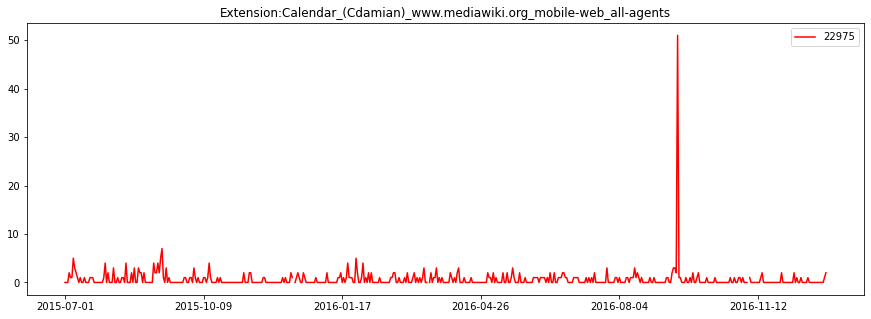

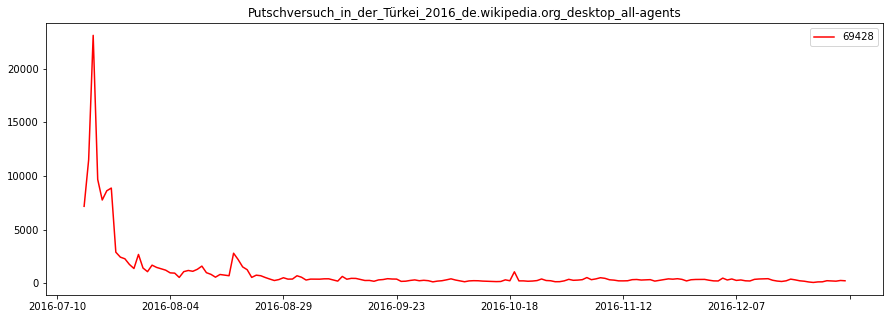

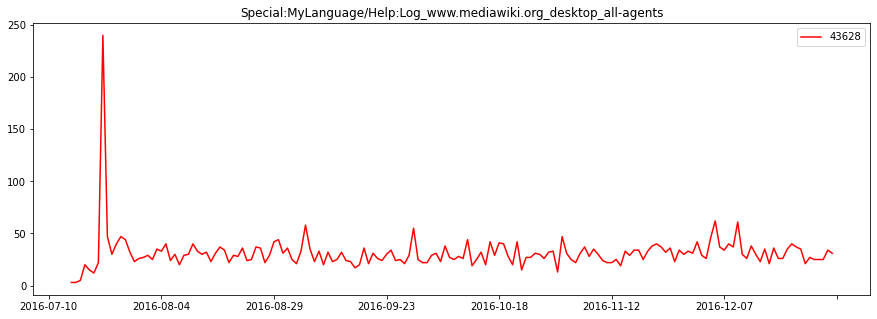

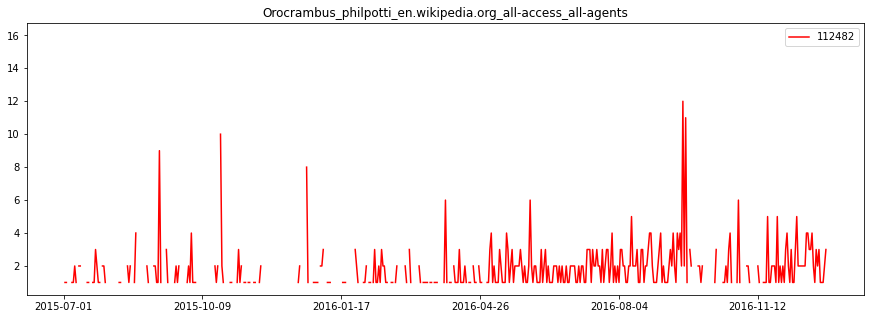

In [162]:
get_sample_ts(nulls.index)

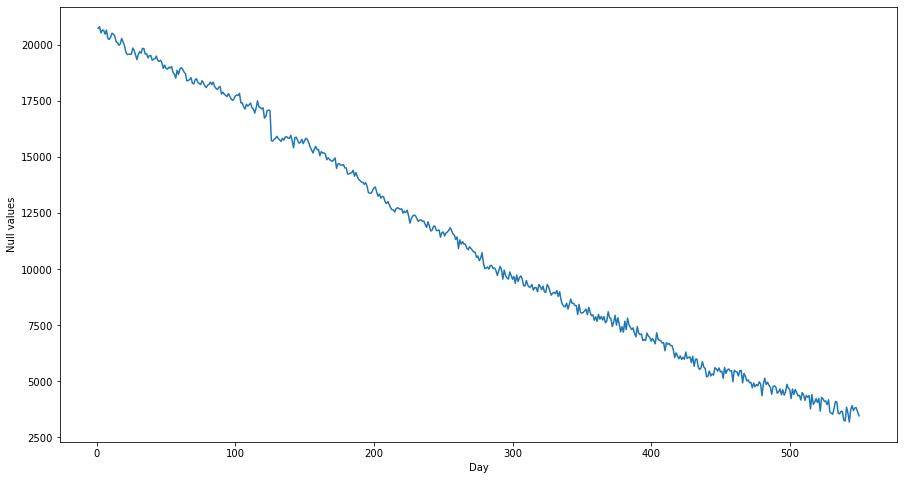

In [163]:
days = [r for r in range(1, len(df.columns))]
plt.figure(figsize=(15,8))
plt.xlabel('Day')
plt.ylabel('Null values')
plt.plot(days, df.isnull().sum()[1:])
plt.show()

### <span style='color:red'>Observations</span>

1. Data has 145k articles and 550 days data.
2. Date range is from 2015-07-01 till 2016-12-31.
3. 7.76% data is missing.
4. 652 articles dont have any visit.
5. There are different variations in missing values plot in each category of page.
6. Some pages dont have visits for whole timeline, just have for short period of time.
7. Null values also showing a kind of time series with downtrend.

In [164]:
# understand page format
df.sample(10)['Page'].tolist()

['Commons:Photo_challenge/2016_-_January_-_Diagonals_commons.wikimedia.org_desktop_all-agents',
 '達文西密碼_(電影)_zh.wikipedia.org_all-access_spider',
 'ケンブリッジ飛鳥_ja.wikipedia.org_desktop_all-agents',
 'Ironman_fr.wikipedia.org_desktop_all-agents',
 '20_de_noviembre_es.wikipedia.org_mobile-web_all-agents',
 'Fête_nationale_du_Québec_fr.wikipedia.org_mobile-web_all-agents',
 "Football_at_the_2016_Summer_Olympics_–_Women's_tournament_en.wikipedia.org_desktop_all-agents",
 '旋风少女_zh.wikipedia.org_all-access_all-agents',
 'The_Space_Between_Us_(film)_en.wikipedia.org_desktop_all-agents',
 '豊川悦司_ja.wikipedia.org_all-access_all-agents']

#### The page name contains data in this format:

SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN

In [165]:
def get_page_info(name):
   
    if 'wikipedia' in name:
        split_word = '.wikipedia.org_'
    elif 'wikimedia' in name:
        split_word  = '.wikimedia.org_'
    else:
        split_word = 'www.mediawiki.org_'

    splits1 = name.split(split_word)[0].split('_')

    title = "_".join(splits1[0:-1])
    language = splits1[-1]
    if len(language) != 2:
        title = "_".join(splits1)
        language = 'other'
        
    try:
        splits2 = name.split(split_word)[1].split('_')
        access_type = splits2[0]
        access_origin = splits2[1]
        
    except Exception as e:
        access_type = 'all-access'
        access_origin = 'all-agents'
    
    return (title, language, access_type, access_origin)
    

In [166]:
df[['title', 'language', 'access_type', 'access_origin']] = df.apply(lambda x: get_page_info(x['Page']), axis=1, result_type='expand')
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,...,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,title,language,access_type,access_origin
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,...,17.0,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0,2NE1,zh,all-access,spider
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,...,19.0,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0,2PM,zh,all-access,spider
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,...,3.0,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0,3C,zh,all-access,spider
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,...,10.0,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0,4minute,zh,all-access,spider
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0,52_Hz_I_Love_You,zh,all-access,spider


In [167]:
df.language.value_counts()

en       24108
ja       20431
de       18547
other    17855
fr       17802
zh       17229
ru       15022
es       14069
Name: language, dtype: int64

In [168]:
df.access_type.value_counts()

all-access    74318
mobile-web    35937
desktop       34808
Name: access_type, dtype: int64

In [169]:
df.access_origin.value_counts()

all-agents    110152
spider         34911
Name: access_origin, dtype: int64

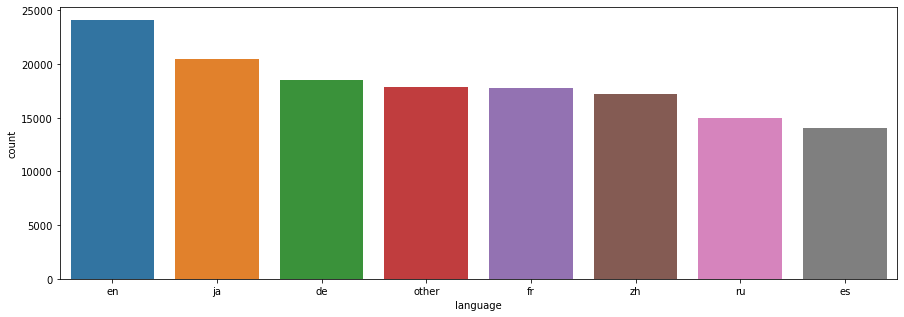

In [170]:
sns.countplot(df.language, order=df.language.value_counts().index)
plt.show()

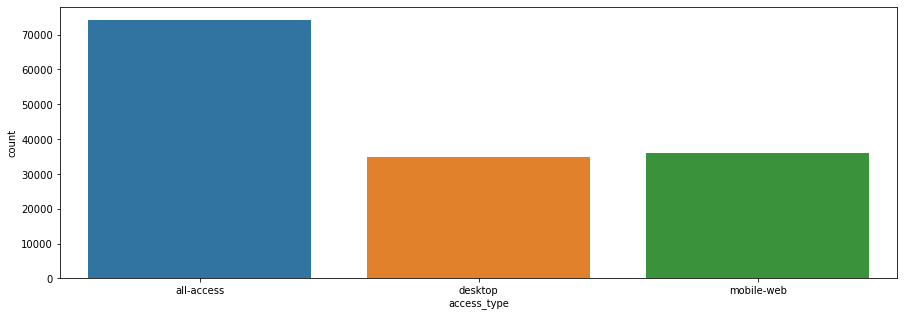

In [171]:
sns.countplot(df.access_type)
plt.show()

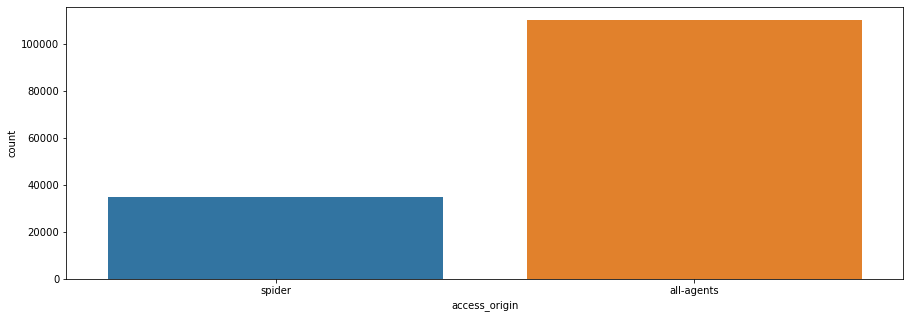

In [172]:
sns.countplot(df.access_origin)
plt.show()

### <span style='color:red'>Observations</span>

1. English language has highest article with 24k counts, where ES is lowest with 14k counts.
2. Most of the articles are in All access type where web and mobile have almost same counts.
3. All agents origin has highest count aprox 110k.

In [173]:
df_copy = df.copy()
df_copy = df_copy.drop(['Page','title', 'access_type', 'access_origin'], axis=1)

In [174]:
df_grouped = df_copy.groupby('language').sum().T
df_grouped.reset_index(inplace=True)
df_grouped = df_grouped.rename(columns={'index':'date'})
df_grouped['date'] = pd.to_datetime(df_grouped['date'])
df_grouped.set_index('date', inplace=True)
df_grouped.head()                

language,de,en,es,fr,ja,other,ru,zh
date,,,,,,,,
2015-07-01,13260519.0,84712190.0,15278553.0,8458638.0,11863200.0,1490534.0,9463854.0,4144988.0
2015-07-02,13079896.0,84438545.0,14601013.0,8512952.0,13620792.0,1561810.0,9627643.0,4151189.0
2015-07-03,12554042.0,80167728.0,13427632.0,8186030.0,12305383.0,1476261.0,8923463.0,4123659.0
2015-07-04,11520379.0,83463204.0,12606538.0,8749842.0,15456239.0,1260073.0,8393214.0,4163448.0
2015-07-05,13392347.0,86198637.0,13710356.0,8590493.0,14827204.0,1396521.0,8938528.0,4441286.0


<AxesSubplot:xlabel='date'>

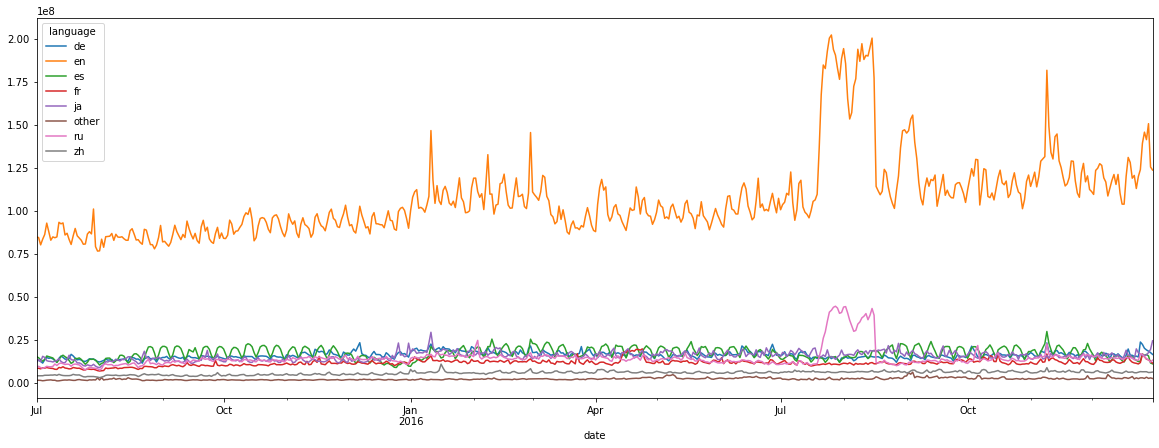

In [175]:
df_grouped.plot(figsize=(20,7))

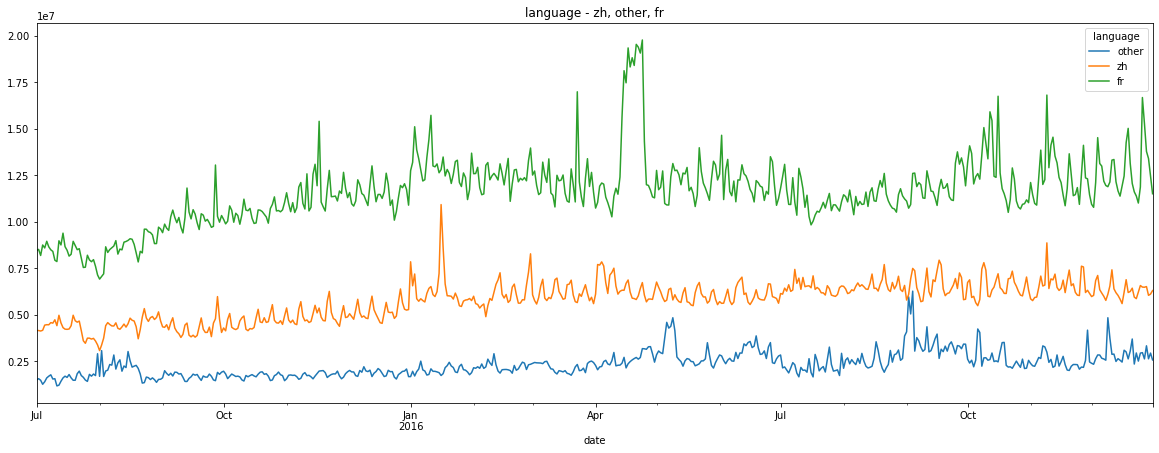

In [176]:
df_grouped[['other','zh','fr']].plot(figsize=(20,7))
plt.title('language - zh, other, fr')
plt.show()

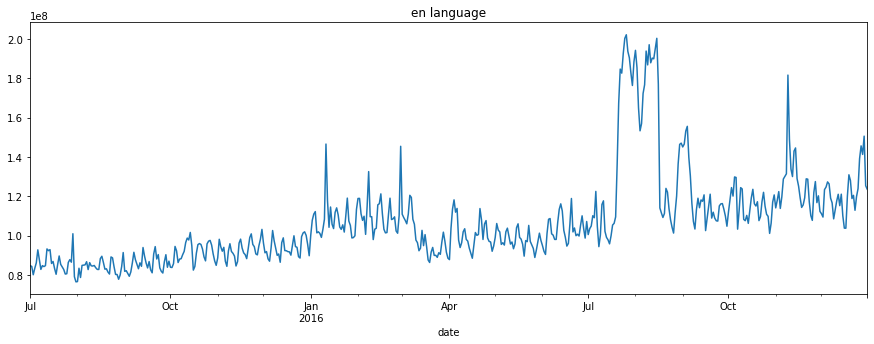

In [177]:
df_grouped.en.plot()
plt.title('en language')
plt.show()

### <span style='color:red'>Observations</span>
1. English language has most number of views and there are some spikes at differnt times may be due to exogenous variable.
2. There are some flat trends for zh, other languages.

### <span style='color:blue'>Stationary TS Check - Dicky fuller test</span>

In [178]:
# df_grouped_copy = df_grouped.copy()

Lets check for en language
- Null hypothesis - TS is not stationary 
- Alternative hypothesis - TS is stationary
- alpha = 5%

In [179]:
en_ts = df_grouped[['en']]
en_ts.head()

language,en
date,
2015-07-01,84712190.0
2015-07-02,84438545.0
2015-07-03,80167728.0
2015-07-04,83463204.0
2015-07-05,86198637.0


In [180]:
def get_stationary_status(ts, alpha=0.05):
    p_val = sm.tsa.stattools.adfuller(ts)[1]
    print('P value is: ', p_val.round(2))
    if p_val > alpha:
        res =  "Time series is not stationary"
    else:
        res =  'Time series is stationary'
        
    print(res)

In [181]:
get_stationary_status(en_ts)

P value is:  0.19
Time series is not stationary


P value is 19% so we can say that we are failed to reject the null hypothesis as our TS is non stationary.

### <span style='color:blue'>Decomposition of timeseries to make it stationary</span>

In [182]:
import statsmodels.api as sm

model = sm.tsa.seasonal_decompose(en_ts)

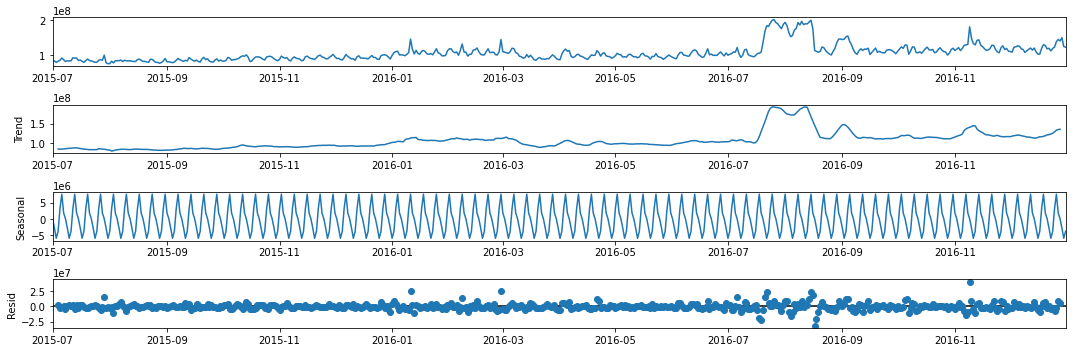

In [183]:
model.plot();

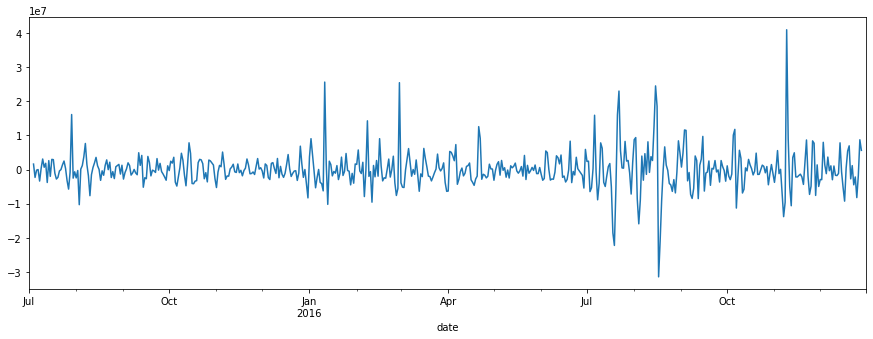

In [184]:
model.resid.plot()
plt.show()

In [185]:
get_stationary_status(model.resid.dropna())

P value is:  0.0
Time series is stationary


#### By residual values, we are getting stationary timeseries.

### <span style='color:blue'>Differencing the series to make it stationary</span> 

In [186]:
en_ts_diff = en_ts.diff()
en_ts_diff.head()

language,en
date,
2015-07-01,NaN
2015-07-02,-273645.0
2015-07-03,-4270817.0
2015-07-04,3295476.0
2015-07-05,2735433.0


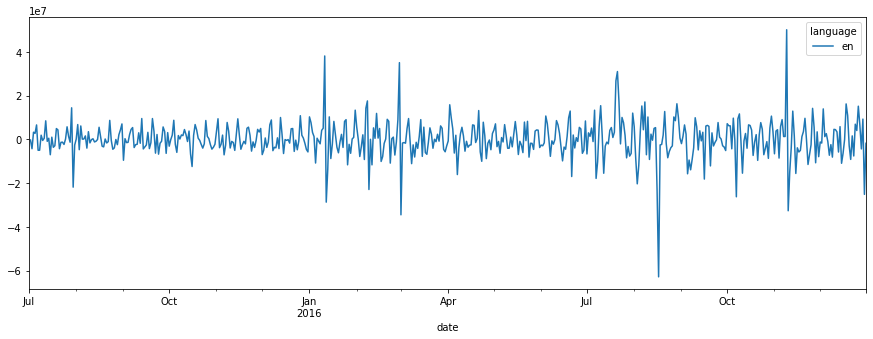

In [187]:
en_ts_diff.plot()
plt.show()

In [188]:
get_stationary_status(en_ts_diff.dropna())

P value is:  0.0
Time series is stationary


#### Diff time series is also a stationary timeseries.

### <span style='color:blue'>Plotting the ACF and PACF plots</span>  

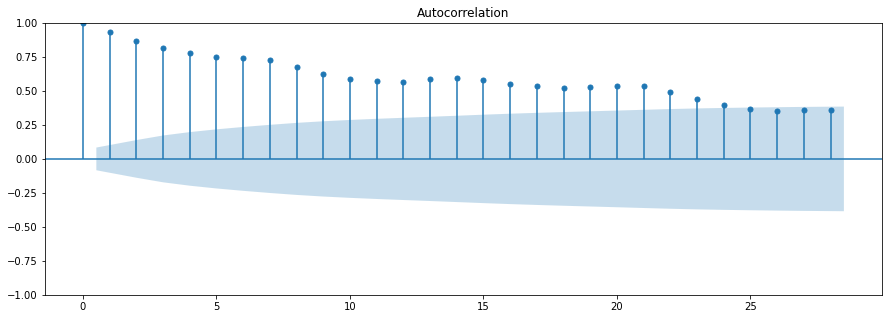

In [189]:
plot_acf(en_ts);

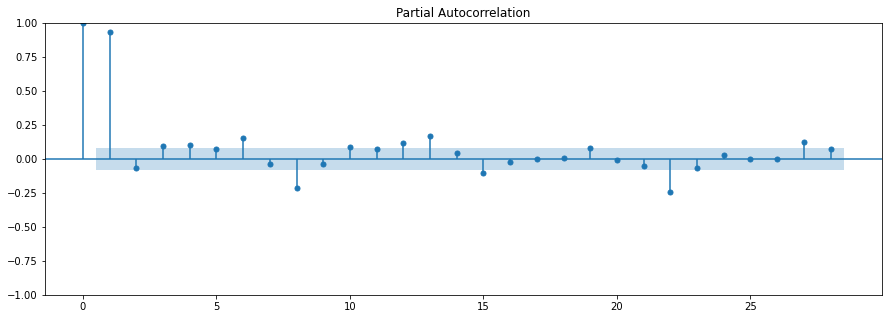

In [190]:
plot_pacf(en_ts);

#### <span style='color:green'>Observations</span>  
1. In acf plot, we can see weak seasonlity and significant values are till 25 only.
2. IN pacf, getting very low corr on 7th, 14th values, not very high correlated

### <span style='color:blue'>ARIMA Modeling</span>  

In [191]:
en_ts_diff  = en_ts_diff.dropna()
en_ts_diff.head()

language,en
date,
2015-07-02,-273645.0
2015-07-03,-4270817.0
2015-07-04,3295476.0
2015-07-05,2735433.0
2015-07-06,6610799.0


In [192]:
train_x = en_ts_diff.loc[en_ts_diff.index < en_ts_diff.index[-24]].copy()
test_x = en_ts_diff.loc[en_ts_diff.index >= en_ts_diff.index[-25]].copy()

test_x.head()


language,en
date,
2016-12-07,-7254209.0
2016-12-08,-2402727.0
2016-12-09,-8107959.0
2016-12-10,4594799.0
2016-12-11,4460867.0


In [193]:
len(train_x)

525

In [194]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae, 
    mean_absolute_percentage_error as mape
)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3)) 
    print('MAPE:', round(mape(actual, predicted), 3))

MAE : 8557176.662
RMSE : 10992421.949
MAPE: 9.001


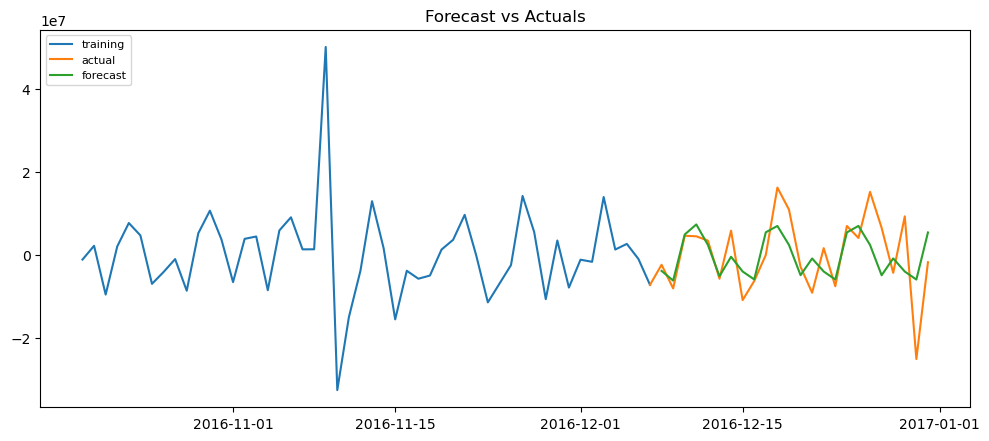

In [195]:
model = SARIMAX(train_x, order=(1, 1, 1), seasonal_order=(1,1,1,7))  
fitted = model.fit(disp=-1)  

# Forecast
fc = fitted.forecast(25, alpha=0.02)  

performance(test_x, fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_x.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_x[-50:], label='training')
plt.plot(test_x, label='actual')
plt.plot(fc_series, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

Forcast level is fine but seasaonilty is missing in this. Lets add the exog variables.

In [196]:
exog_df.head()

,Exog
0,0
1,0
2,0
3,0
4,0


In [197]:
exog = exog_df.Exog.to_numpy()
len(exog)

550

In [198]:
len(test_x)

25

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.71920D+01    |proj g|=  7.31103D-02

At iterate    5    f=  1.71492D+01    |proj g|=  1.95004D-02

At iterate   10    f=  1.71486D+01    |proj g|=  8.14757D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     14      1     0     0   6.649D-06   1.715D+01
  F =   17.148610941919245     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
MAE : 11293946.38
RMSE : 16165334.139
MAPE: 6.951


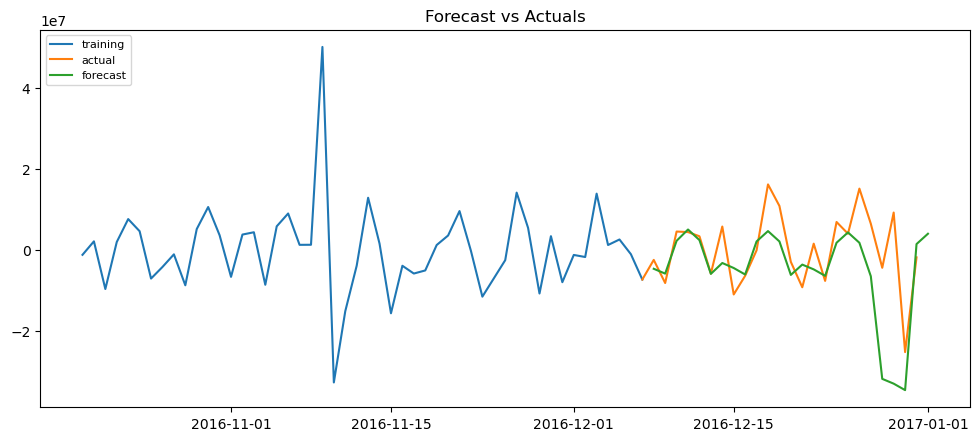

In [199]:
model=sm.tsa.statespace.SARIMAX(train_x, order=(1, 1, 1),seasonal_order=(1,1,1,7),exog=exog[:525])
results=model.fit()

fc=results.forecast(25,dynamic=True,exog=pd.DataFrame(exog[525:]))

performance(test_x, fc)
# Make as pandas series
fc_series = pd.Series(fc)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_x[-50:], label='training')
plt.plot(test_x, label='actual')
plt.plot(fc_series, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Seasonlity has covered very well with exog variable.

### <span style='color:blue'>Facebook Prophet</span>  

In [200]:
from prophet import Prophet

In [201]:
en_ts_df = en_ts.reset_index().copy()

en_ts_df['exog'] = exog
en_ts_df.columns = ['ds', 'y', 'exog']
en_ts_df.head()

,ds,y,exog
0,2015-07-01,84712190.0,0
1,2015-07-02,84438545.0,0
2,2015-07-03,80167728.0,0
3,2015-07-04,83463204.0,0
4,2015-07-05,86198637.0,0


01:38:24 - cmdstanpy - INFO - Chain [1] start processing
01:38:24 - cmdstanpy - INFO - Chain [1] done processing


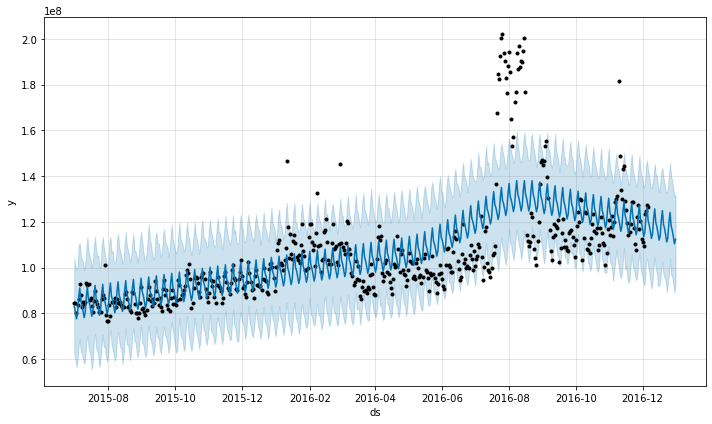

In [202]:
#without exogenous

model = Prophet(weekly_seasonality=True)
model.fit(en_ts_df[['ds', 'y']][:-25]) 
future = model.make_future_dataframe(periods=25,freq="D")

forecast = model.predict(future)
fig = model.plot(forecast)

01:38:24 - cmdstanpy - INFO - Chain [1] start processing
01:38:24 - cmdstanpy - INFO - Chain [1] done processing


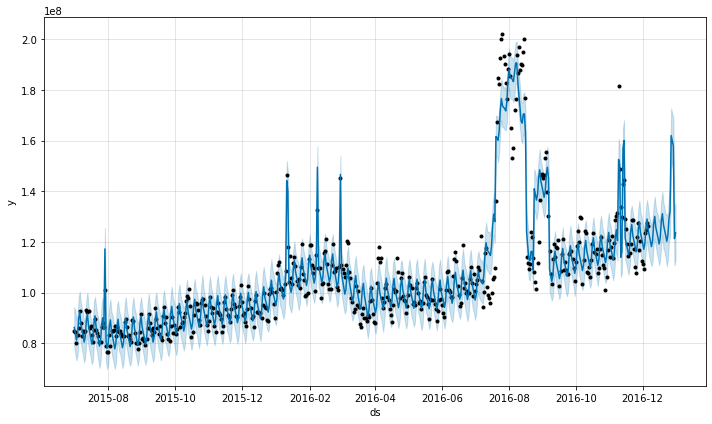

In [203]:
#with exogenous 

model2 = Prophet(interval_width=0.7, weekly_seasonality=True, changepoint_prior_scale=1)
model2.add_regressor('exog') 
model2.fit(en_ts_df[:-25])
forecast2 = model2.predict(en_ts_df)
fig = model2.plot(forecast2)

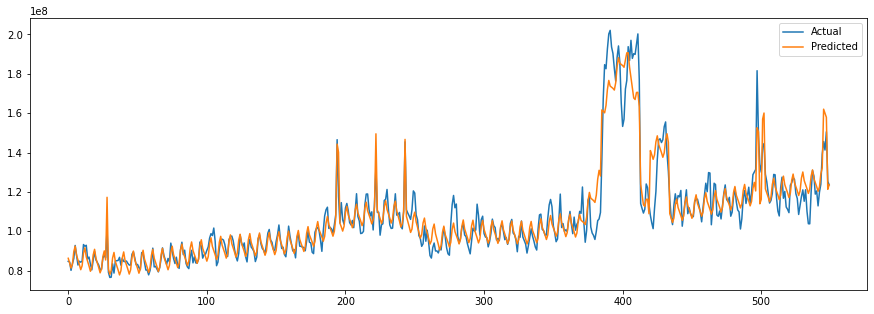

In [204]:
#plot both actual and predicted

y_true = en_ts_df['y'].values
y_pred = forecast2['yhat'].values

plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [205]:
print('MAPE score is: ',mape(en_ts_df['y'][-25:], forecast2['yhat'][-25:].values))

MAPE score is:  0.06232661947250681


Actual and prophet predicted series is very much same and following the actual one properly. So we can conclude that prophet is working fine here.

### <span style='color:blue'>Working with other languages</span>  

In [206]:
def grid_search_ts(train_x, test_x, lang):
    order=[1,2,3]
    mape=1
    
    final_vals = [0,0,0]
    for p in order:
        for d in order:
            for q in order:
                try:
                    model = SARIMAX(train_x, order=(p,d,q))
                    model_fit = model.fit(disp=-1)
                    fc = model_fit.forecast(25, alpha=0.02)
                    map_res = np.mean(np.abs(fc.values - test_x.values)/np.abs(test_x.values))
                    
                    if map_res < mape:
                        mape=map_res
                        final_vals=[p,d,q]

                except Exception as e:
                    print(e)
    print('best p,d, q values are:,', final_vals)
    print(f'best mape for {lang} is {mape}')
    
    
    model = SARIMAX(train_x, order=(final_vals[0], final_vals[1], final_vals[2]))  
    fitted = model.fit(disp=-1)  
    fc = fitted.forecast(25, alpha=0.02)  
    
    fc_series = pd.Series(fc.values, index=test_x.index)

    print('MAPE: ', np.mean(np.abs(fc.values - test_x.values)/np.abs(test_x.values)))
    print('MSE: ', mse(test_x, fc))
    
    
    plt.figure(figsize=(15,8))
    plt.plot(train_x, label='training')
    plt.plot(test_x, label='actual')
    plt.plot(fc_series, label='forecast')
    title = 'Forecast vs Actuals for '+ lang
    plt.title(title)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    
    return fc


TS for language:  de
best p,d, q values are:, [3, 1, 1]
best mape for de is 0.08941770808707546
MAPE:  0.08941770808707546
MSE:  6346724482936.318


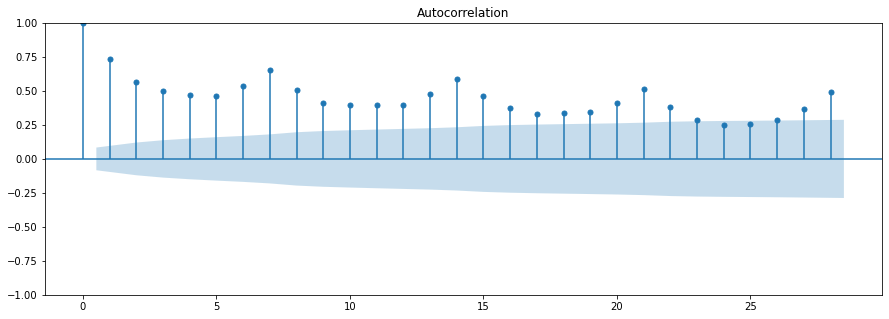

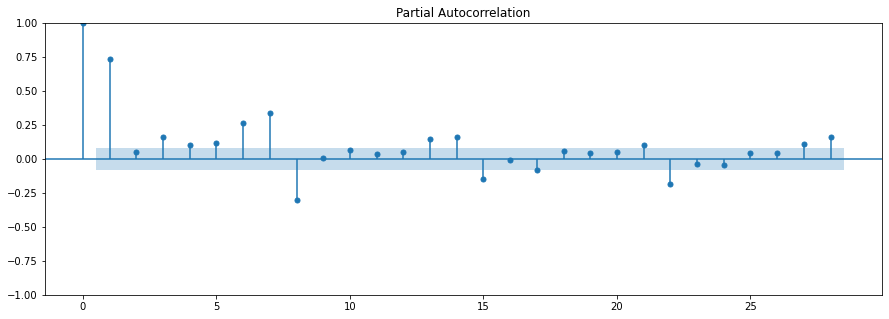

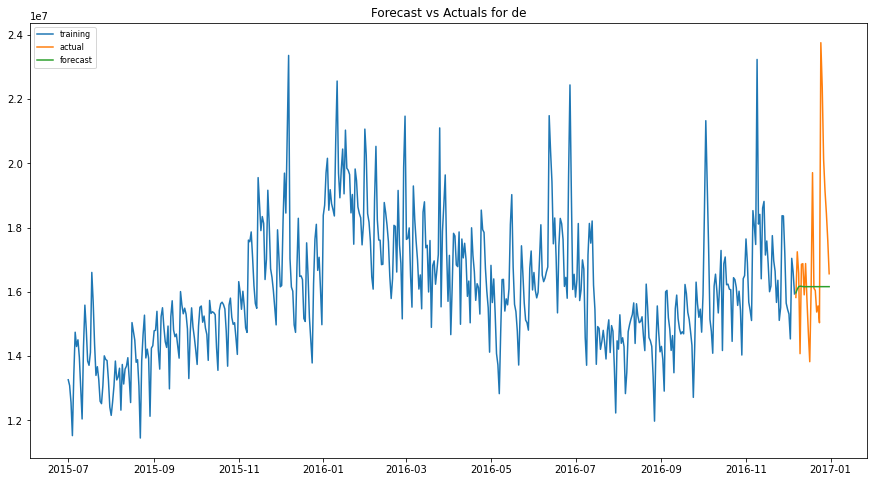

TS for language:  en
best p,d, q values are:, [1, 3, 2]
best mape for en is 0.0729510118808917
MAPE:  0.0729510118808917
MSE:  187592305647011.44


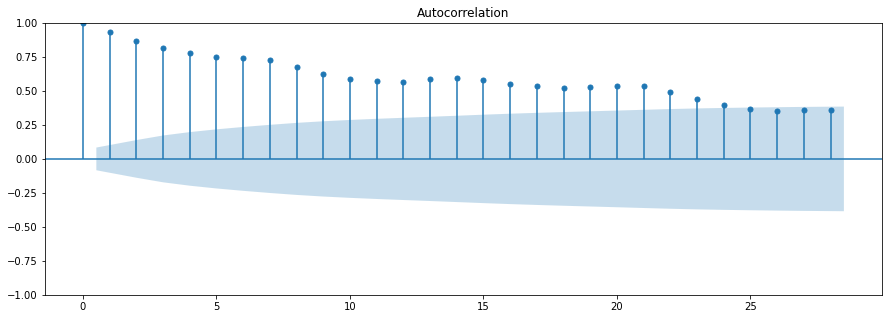

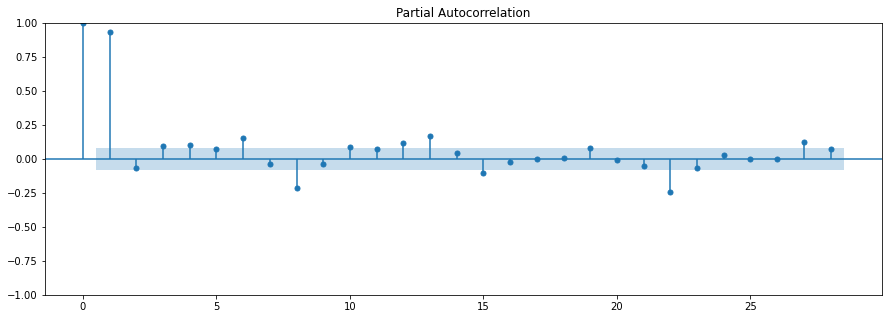

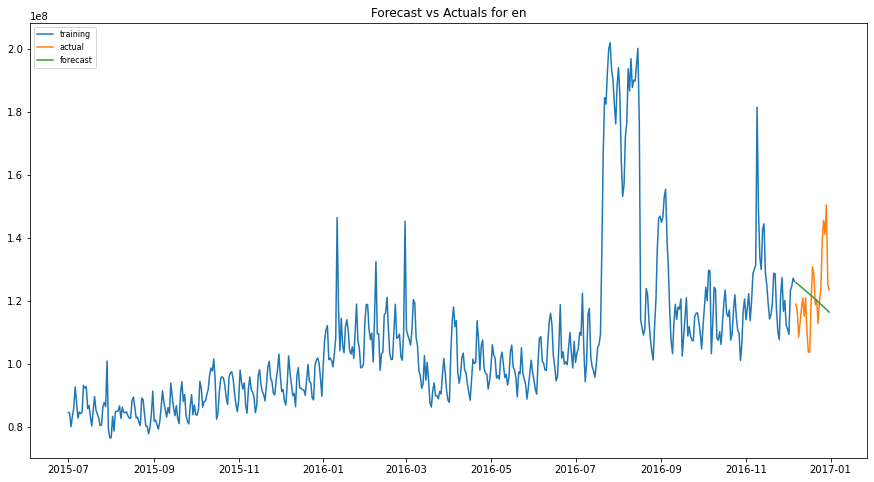

TS for language:  es
best p,d, q values are:, [3, 3, 2]
best mape for es is 0.1247723378319352
MAPE:  0.1247723378319352
MSE:  3798926881531.3496


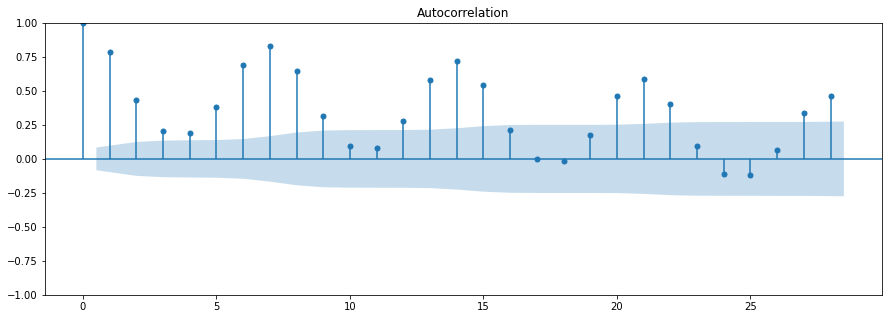

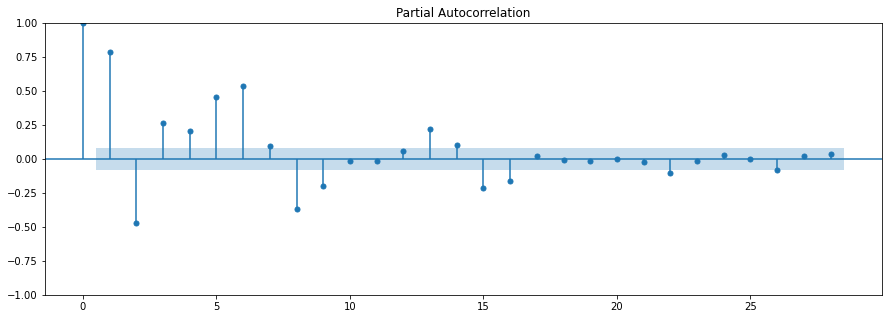

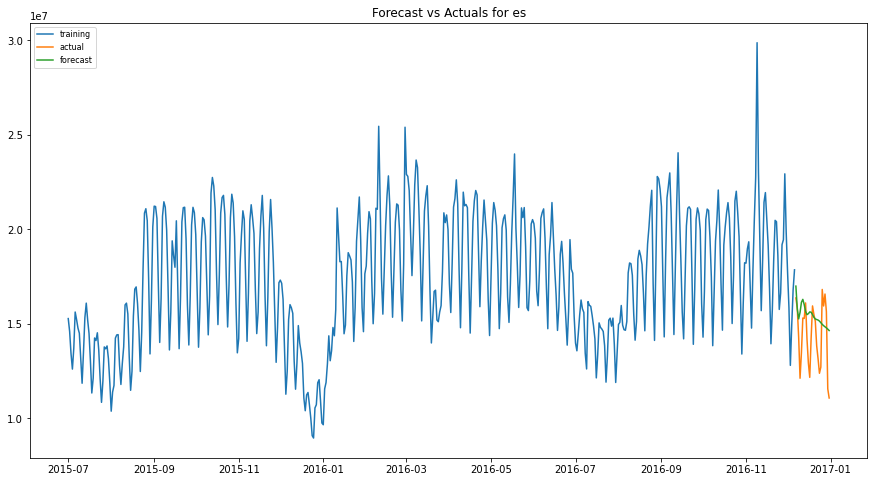

TS for language:  fr
best p,d, q values are:, [1, 1, 1]
best mape for fr is 0.07832977203584054
MAPE:  0.07832977203584054
MSE:  1971404203551.154


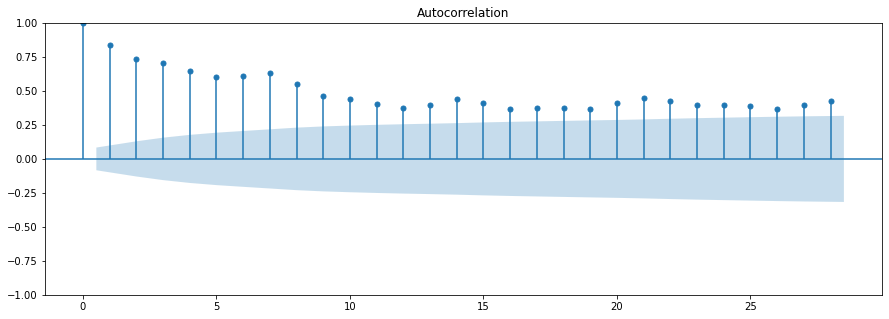

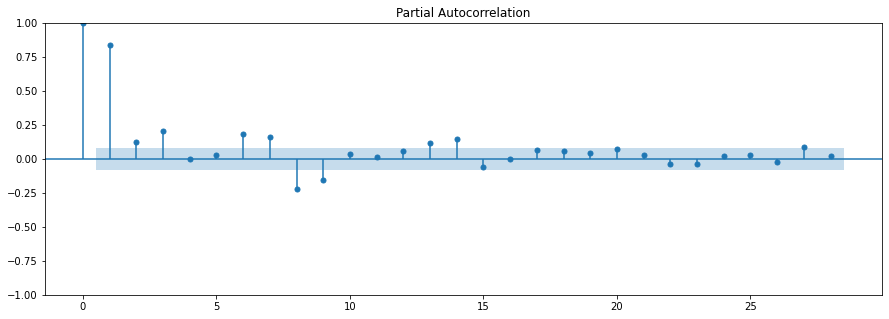

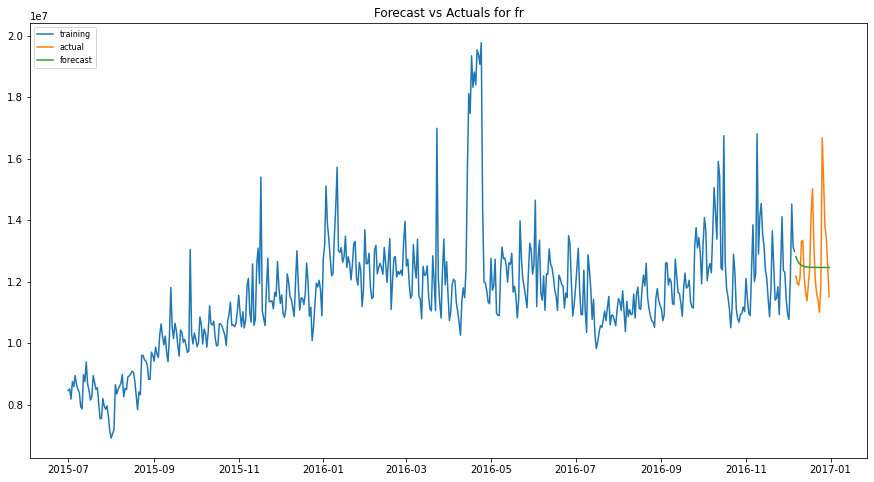

TS for language:  ja
best p,d, q values are:, [1, 2, 3]
best mape for ja is 0.09809691683963565
MAPE:  0.09809691683963565
MSE:  6682656472407.52


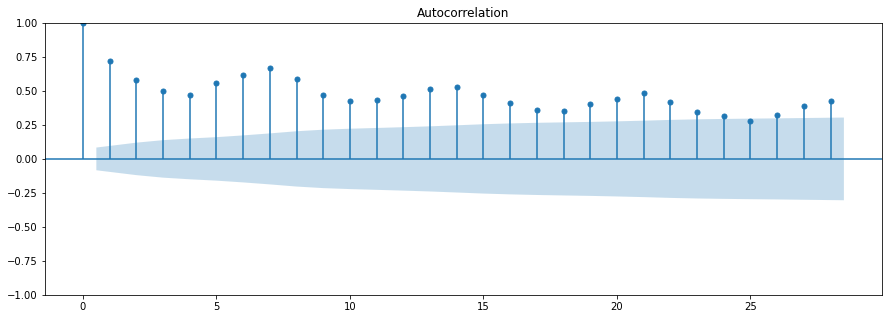

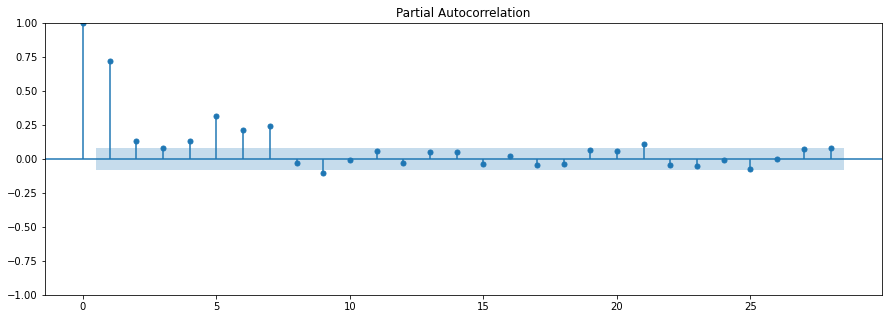

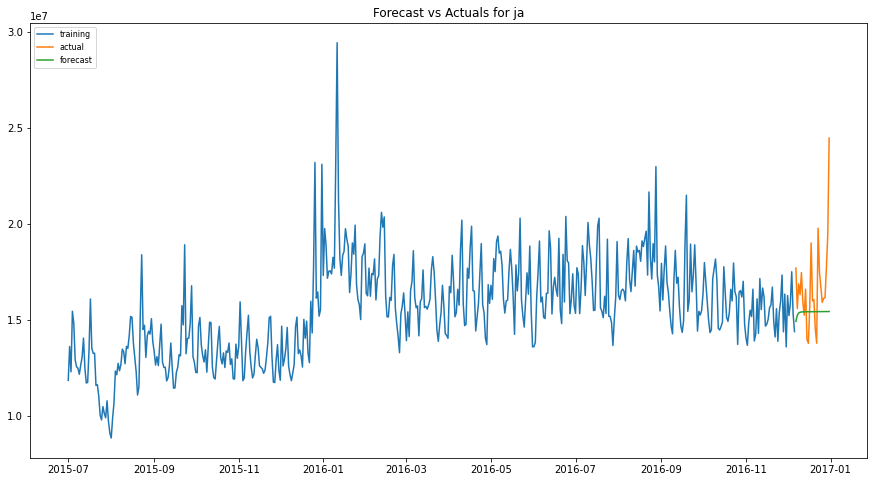

TS for language:  other
best p,d, q values are:, [1, 1, 3]
best mape for other is 0.10627917110462827
MAPE:  0.10627917110462827
MSE:  345342431234.24567


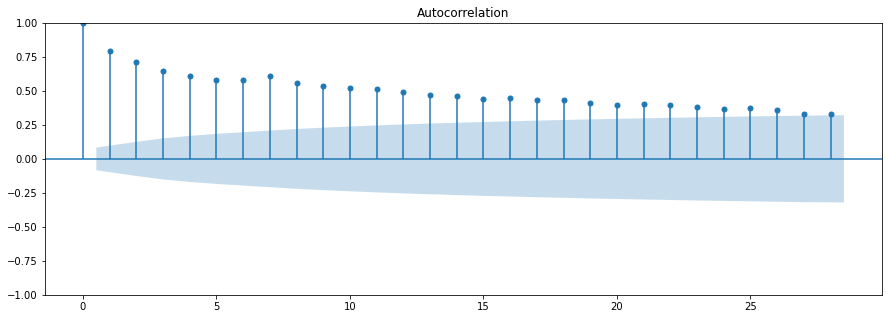

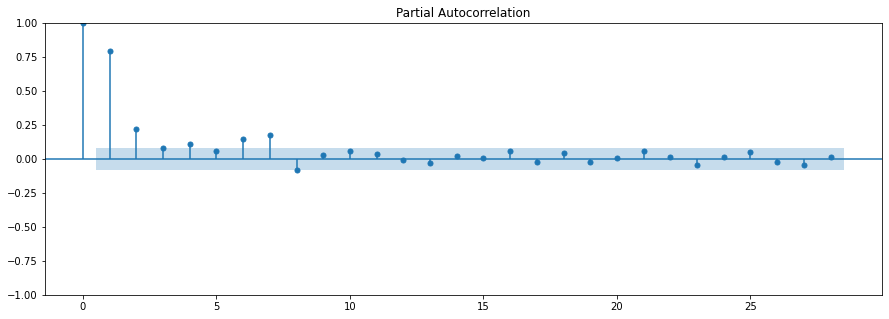

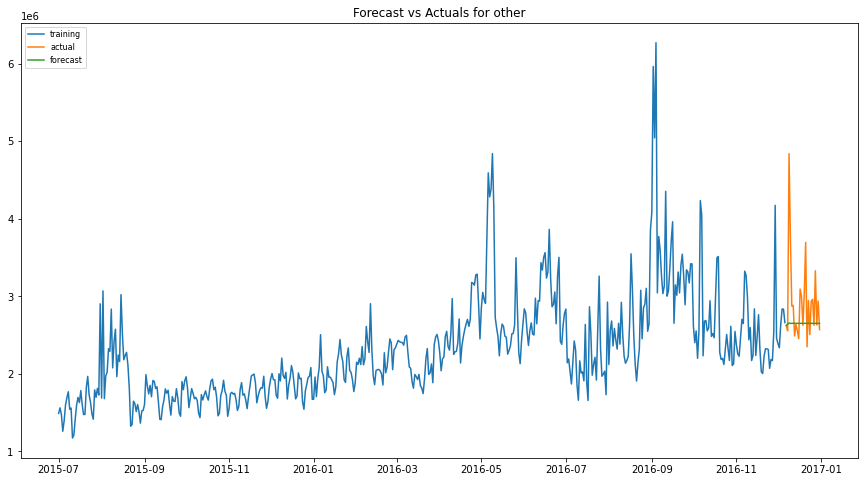

TS for language:  ru
best p,d, q values are:, [1, 3, 3]
best mape for ru is 0.05012295347110419
MAPE:  0.05012295347110419
MSE:  982794590913.2181


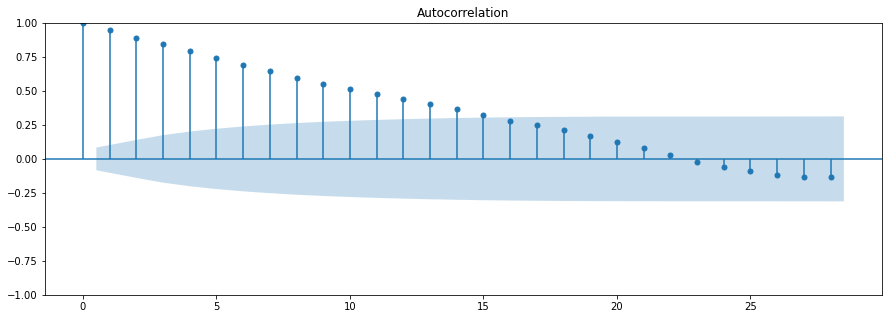

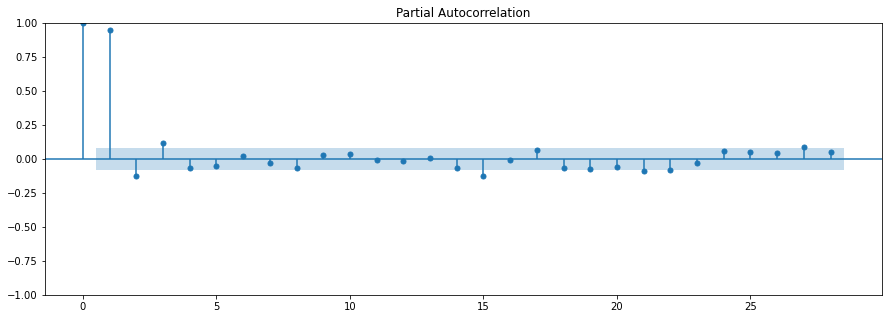

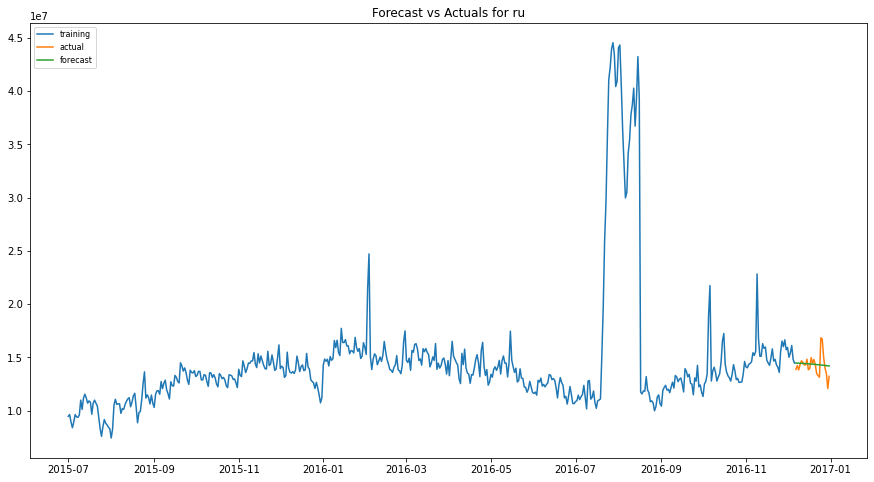

TS for language:  zh
best p,d, q values are:, [3, 3, 3]
best mape for zh is 0.04400989837755993
MAPE:  0.04400989837755993
MSE:  142034966477.4644


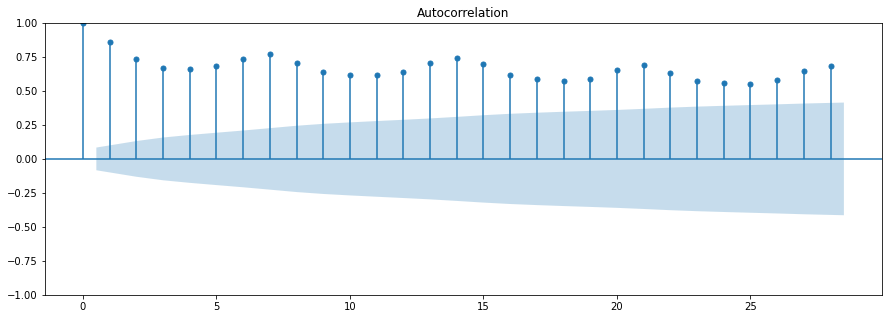

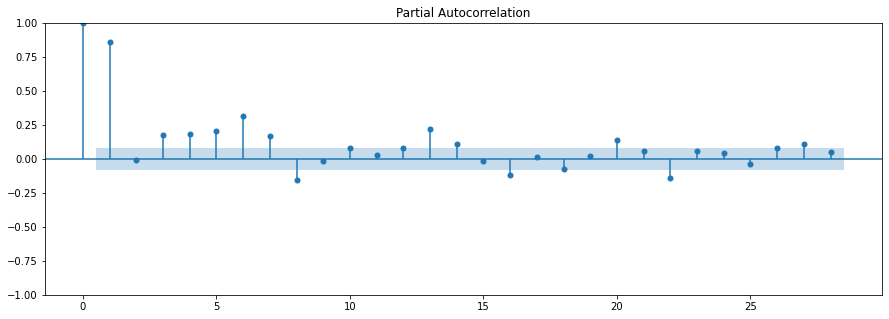

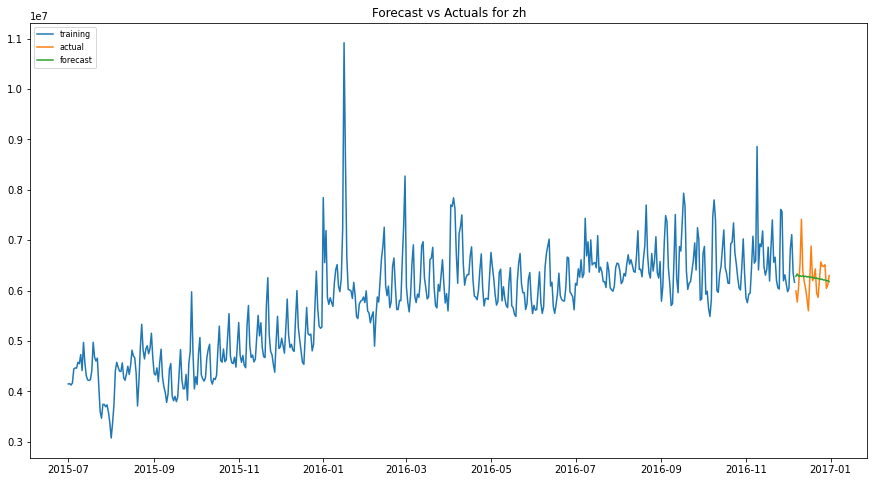

In [207]:
preds = {}
for lang in df_grouped.columns:
    print("TS for language: ",lang)
    
    lang_ts = (df_grouped[[lang]])
    
    # lang_ts = lang_ts.diff().dropna()
    # get_stationary_status(lang_ts)
    
    train_x = lang_ts[:-25]
    test_x = lang_ts[-25:]
    
    plot_acf(lang_ts);
    plot_pacf(lang_ts);
    
    fc=grid_search_ts(train_x, test_x, lang)
    
    preds[lang]=fc

### <span style='color:blue'>Questionnaire</span>   

#### 1. Defining the problem statements and where can this and modifications of this be used?
Need to forcast number of visits on each language pages so business can allocate budget for each group and optimize ad.
Can use similar kind of model for other domain forcasting like future demand on any product so business optimize the production.


#### 2. Write 3 inferences you made from the data visualizations
- English language has most of the views.
- Desktop and mobile web almost same counts of views.
- Exogenous variable has very good correlation with english lang pages.


#### 3. What does the decomposition of series do?
Decomposition seperate trend, season and residual from time series. We can visulize all seprately and get insights.
Residual plot is useful to get stationary time series.


#### 4. What level of differencing gave you a stationary series?
Usually first level of differencing provide stationary series, else we can go with second level of differencing.



#### 5. Difference between arima, sarima & sarimax.
ARIMA - Auto-Regressive Integrated Moving Average
Where SARIMA contains seasonal factor with ARIMA, can provide strong forcasting.
SARIMAX contains exogenous variable into factor and more powerful than ARIMA and SARIMA.


#### 6.Compare the number of views in different languages
- English language has most number of views.
- Other and ZH have least number of views and very flat curves are there.


#### 7. What other methods other than grid search would be suitable to get the model for all languages?
Random search is also a good option to reduce time complexity and get results faster.